# Прогнозирование заказов такси

В рамках проекта перед нами стоит задача по построению модели, которая сможет предсказать количество заказов такси в аэророрту в пиковые часы. Заказчиком представлены исторические данные о заказе такси в аэропортах.

На основе предсказаний модели заказчик планирует привлечь соразмерное количество водителей в пиковые часы, поэтому важна точность предсказания. Целевая метрика RMSE должна быть ниже 48.

### Извлечем и проведем первичный анализ представленных данных

### Импортируем библиотеки, которые будут использоваться в проекте

In [1]:
#!pip install lightgbm

In [2]:
import copy
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy. stats import boxcox 
import time
import warnings
from datetime import datetime
from joblib import (
    Parallel,
    delayed
)
from lightgbm import LGBMRegressor
from math import sqrt
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
print("Версия LightGBM: ", lgb.__version__)

Версия LightGBM:  3.3.3


In [4]:
data_pth1 = 'C:\\Dataset\\taxi.csv'
data_pth2 = '/datasets/taxi.csv'

if os.path.exists(data_pth1):
    df = pd.read_csv(data_pth1)
elif os.path.exists(data_pth2):
    df = pd.read_csv(data_pth2)
else:
    print("Проверьте путь к датасету")

pd.set_option('display.max_columns', 90)

### Проведем первичный анализ данных и их предобработку

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В данных нет пропусков. Представлены данные о количестве заказов и их временная метка.

Столбец datetime нужно привести в соответствующий формат.

In [6]:
df.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [7]:
df['datetime'] = pd.to_datetime(
    df['datetime'],
    format='%Y-%m-%d %H:%M:%S'
) 

Привели данные к формату datetime64

In [8]:
df = df.set_index('datetime')

Проиндексировали по дате и отсортировали

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нам доступны данные за 5 месяце 2018 года. Период с начала марта по конец августа.

In [10]:
df = df.astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int32
dtypes: int32(1)
memory usage: 310.5 KB


На 15% уменьшили объем памяти, занимаемый датасетом

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


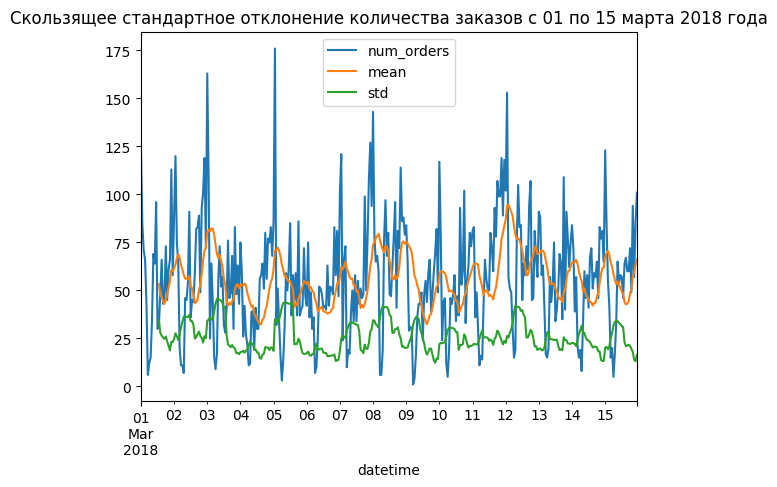

In [12]:
df_sliding = df['2018-03-01':'2018-03-15'].resample('1H').sum()
df_sliding['mean'] = df_sliding['num_orders'].rolling(14).mean()
df_sliding['std'] = df_sliding['num_orders'].rolling(14).std()
df_sliding.plot()
plt.title(
    "Cкользящее стандартное отклонение количества заказов с 01 по 15 марта 2018 года"
)
plt.show()

Распределение не является стационарным. Со временем меняется и среднее и стандартное.

In [13]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В данных имеюся выбросы, которые мы и должны верно предсказать. Среднее смещено в большую сторону. Соответственно пиковых значений больше нулевых.

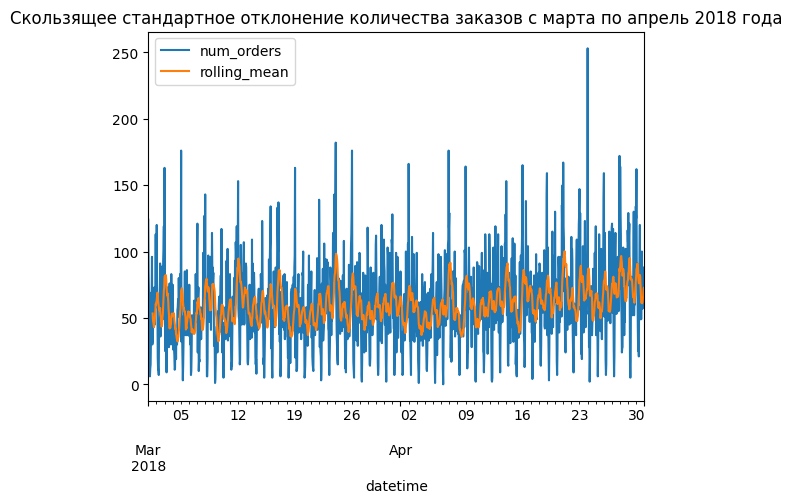

In [14]:
data = df['2018-03':'2018-04'].resample('1H').sum()
data['rolling_mean'] = data.rolling(14).mean() 
data.plot()
plt.title(
    "Cкользящее стандартное отклонение количества заказов с марта по апрель 2018 года"
)
plt.show()

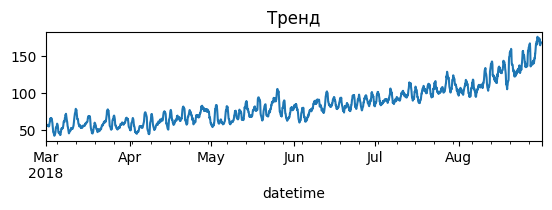

In [15]:
data = df['2018-03':'2018-08'].resample('1H').sum()
decomposed = seasonal_decompose(data)
decomposed_trend = decomposed.trend['2018-01':'2018-08']
plt.subplot(313)
decomposed_trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.show()

Прослеживается восходящий тренд. 

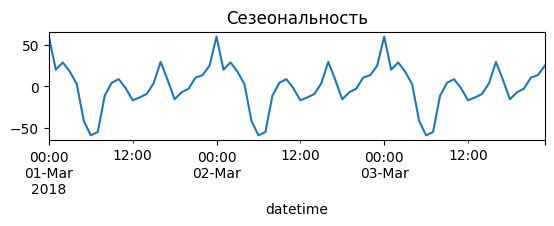

In [16]:
decomposed_seasonal = decomposed.seasonal['2018-03-01':'2018-03-3']
plt.subplot(313)
decomposed_seasonal.plot(ax=plt.gca())
plt.title('Сезеональность')
plt.show()

Похоже, что сезонность выражена в ежедневных повторяющихся циклах.

<a id='tag_1'></a>

In [17]:
df = df.resample('1H').sum()

#### Введем новые признаки с привязкой ко времени

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    make_features_df = copy.deepcopy(data)
    make_features_df['month'] = make_features_df.index.month # Поскольку данные за один год, верхний порог будет месяцем
    make_features_df['day'] = make_features_df.index.day
    make_features_df['hours'] = make_features_df.index.hour
    make_features_df['dayofweek'] = make_features_df.index.dayofweek + 1 # Добавим дни недели. В выходные трафик наверняка выше   
    for lag in range(1, max_lag + 1): # Вычисление отстающих значений
        make_features_df['lag_{}'.format(lag)] = make_features_df['num_orders'].shift(lag)
        
    make_features_df['rolling_mean'] = make_features_df['lag_1'].rolling(rolling_mean_size).mean() 
    # Cкользящее стандартное отклонение
    return make_features_df

In [19]:
make_features_df = make_features(df, 1, 24)
make_features_df.head(15)

,num_orders,month,day,hours,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,4,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,4,124.0,NaN
2018-03-01 02:00:00,71,3,1,2,4,85.0,NaN
2018-03-01 03:00:00,66,3,1,3,4,71.0,NaN
2018-03-01 04:00:00,43,3,1,4,4,66.0,NaN
2018-03-01 05:00:00,6,3,1,5,4,43.0,NaN
2018-03-01 06:00:00,12,3,1,6,4,6.0,NaN
2018-03-01 07:00:00,15,3,1,7,4,12.0,NaN
2018-03-01 08:00:00,34,3,1,8,4,15.0,NaN


In [20]:
make_features_df = make_features(df, 24*7, 24)
make_features_df = make_features_df.dropna()

### Обучим модели

#### Разделим датасет на обучающую, валидационную и тестовую выборки

In [21]:
X = make_features_df.drop('num_orders', axis=1)
y = make_features_df['num_orders']

train_future, temp_future, train_target, y_temp = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=.2,
    random_state=12345
)

    
val_future, test_future, val_target, test_target = train_test_split(
    temp_future,
    y_temp, shuffle=False,
    test_size=.5,
    random_state=12345
)


In [22]:
print(
    train_future.shape,
    train_target.shape,
    val_future.shape,
    val_target.shape, 
    test_future.shape,
    test_target.shape
)

(3398, 173) (3398,) (425, 173) (425,) (425, 173) (425,)


In [23]:
def predict_and_score(model, future, target): # функция вычисления предсказания и целевой метрики RMSE
    predict = model.predict(future)
    RMSE = (mean_squared_error(target, predict)) ** .5
    return RMSE, predict

In [24]:
def train_and_score(model, train_future, train_target):
    score = []
    tscv = TimeSeriesSplit(n_splits=21)
    X = train_future.reset_index(drop=True)
    y = train_target.reset_index(drop=True)

    for train_index, test_index in tscv.split(train_future):  
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        score.append((mean_squared_error(y_test, predict)) ** .5)

    print(
        'Средний RMSE на обучающей выборке {:.2f}'.format(
            pd.Series(score).mean()
        )
    )
    return model

In [25]:
def plot_by_predict(prediction, target): # Помтроение графика с учетом смещения лямда после преобразования Бокса-Кокса 
    predicted = pd.Series(
        prediction ,
        index=target.index.astype('datetime64[ns]')
    )
    plt.plot(target.rolling(
        window=31,
        min_periods=30
    ).mean())
    plt.plot(predicted.rolling(
        window=31,
        min_periods=30).mean(),
        color='red'
    )
    plt.xticks(rotation=45)
    plt.show()

#### Модель решающего древа

In [26]:
%%time
tree_model_basic = DecisionTreeRegressor(random_state=12345)


tree_model_basic = train_and_score(
    tree_model_basic,
    train_future,
    train_target
)

RMSE_1, predict_1 = predict_and_score(
    tree_model_basic,
    val_future,
    val_target
)
print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_1)
)

Средний RMSE на обучающей выборке 29.79
На валидационной выборке RMSE = 43.09
CPU times: total: 6.98 s
Wall time: 7.45 s


Очевидно, модель переобучена. RMSE несколько ниже заданного порога.

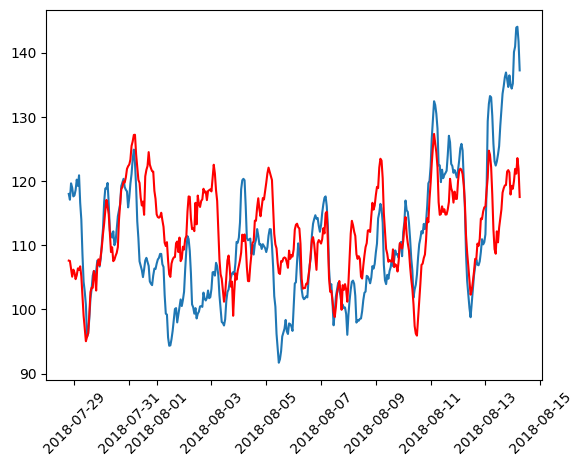

In [27]:
plot_by_predict(predict_1, val_target)

Данная модель нам не подходит. Плохо предсказывает пики нагрузки, в которые и планируется привлекать дополнительных водителей.

#### Модель линейной регрессии

In [28]:
%%time

linear_model = linear_model.Ridge(alpha=1.5)

linear_model = train_and_score(
    linear_model,
    train_future,
    train_target
)

RMSE_2, predict_2 = predict_and_score(
    linear_model,
    val_future,
    val_target
)
print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_2)
)

Средний RMSE на обучающей выборке 24.74
На валидационной выборке RMSE = 29.23
CPU times: total: 719 ms
Wall time: 666 ms


Данная модель также немного переобучена. RMSE ниже заданного порога.

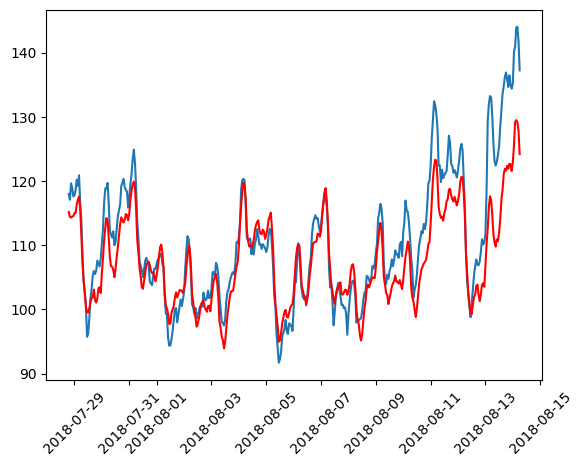

In [29]:
plot_by_predict(predict_2, val_target)

Выглядит лучше других моделей. Однако предсказывает все еще неточное.

#### Градиентный бустинг модели линейной регрессии

In [30]:
%%time
linear_bost_model = GradientBoostingRegressor(random_state=12345)

linear_bost_model = train_and_score(
    linear_bost_model,
    train_future,
    train_target
)

RMSE_3, predict_3 = predict_and_score(
    linear_bost_model,
    val_future,
    val_target
)

print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_3)
)

Средний RMSE на обучающей выборке 20.84
На валидационной выборке RMSE = 30.95
CPU times: total: 2min 6s
Wall time: 2min 9s


И эта модель переобучилась.

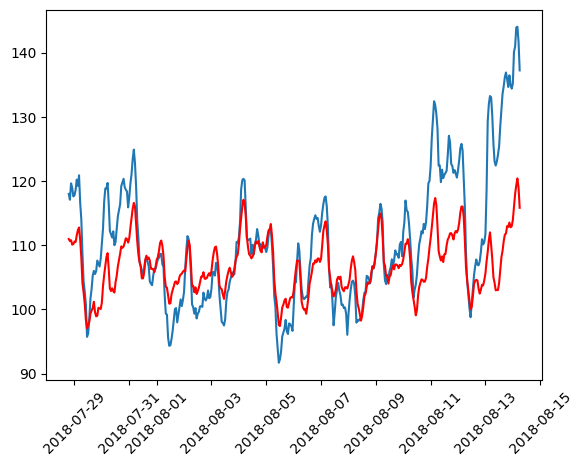

In [31]:
plot_by_predict(predict_3, val_target)

Выбросы модель предсказывает плохо.

#### Подберем параметры для градиентного бустинга LightGBM

In [32]:
%%time

model_lgbm_b = LGBMRegressor(random_state=12345)


model_lgbm_b = train_and_score(
    model_lgbm_b,
    train_future,
    train_target
)

RMSE_6, predict_6 = predict_and_score(
    model_lgbm_b,
    val_future,
    val_target
)

print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_6)
)

Средний RMSE на обучающей выборке 21.03
На валидационной выборке RMSE = 31.27
CPU times: total: 1min
Wall time: 13 s


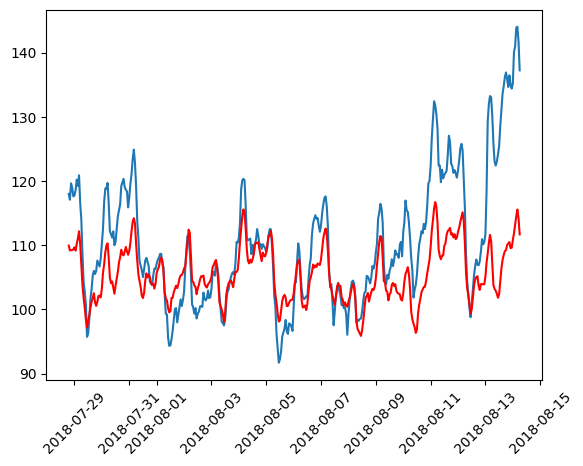

In [33]:
plot_by_predict(predict_6, val_target)

#### Проверим модель случайного леса

In [34]:
%%time

forest_model_basic = RandomForestRegressor(random_state=12345)

forest_model_basic = train_and_score(
    forest_model_basic,
    train_future,
    train_target
)

RMSE_4, predict_4 = predict_and_score(
    forest_model_basic,
    val_future,
    val_target
)
print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_4)
)

Средний RMSE на обучающей выборке 20.69
На валидационной выборке RMSE = 31.30
CPU times: total: 6min 29s
Wall time: 6min 35s


Снова присутствует переобучение. Вместе с тем это лучший показатель RMSE.

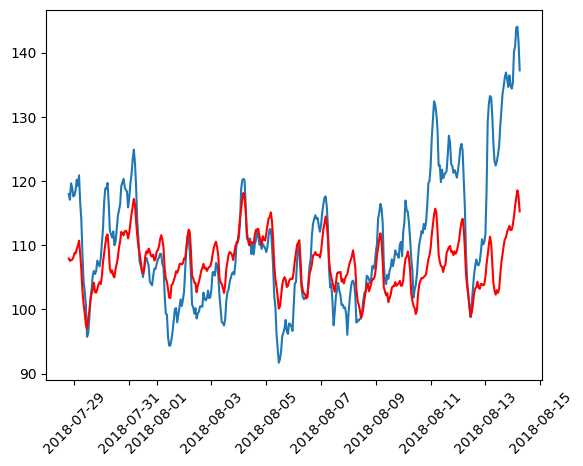

In [35]:
plot_by_predict(predict_4, val_target)

Данная модель плохо предсказывает пики, занижая количество заказов.

##### Посмотрим случайную модель, заполняющую средним для оценки адекватности моделей

In [36]:
%time

pseudorandom_model = DummyRegressor(strategy='mean')

pseudorandom_model = train_and_score(
    pseudorandom_model,
    train_future,
    train_target
)

RMSE_5, predict_5 = predict_and_score(
    pseudorandom_model,
    val_future,
    val_target
)
print(
    'На валидационной выборке RMSE = {:.2f}'.format(RMSE_5)
)

CPU times: total: 0 ns
Wall time: 0 ns
Средний RMSE на обучающей выборке 35.97
На валидационной выборке RMSE = 59.45


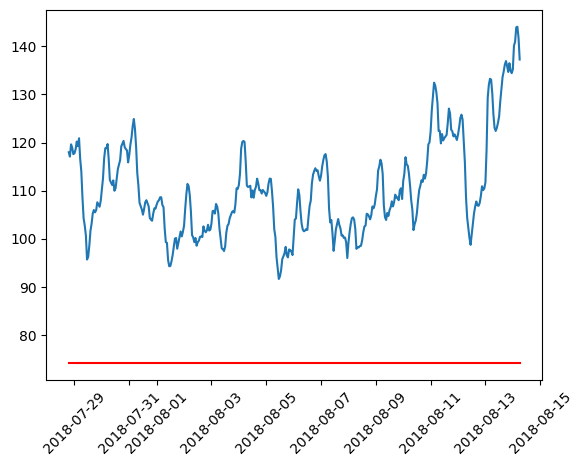

In [37]:
plot_by_predict(predict_5, val_target)

Представленные модели выглядят адекватно. RMSE моделей ощутимо ниже, чем при заполнении средним, а предсказание сопоставимо с целевым признаком.

### Протестируем лучшую модель на тестовой выборке

In [38]:
%time

RMSE_3_0, predict_3_0 = predict_and_score(
    linear_model,
    test_future,
    test_target
)
print(
    'На тестовой выборке RMSE = {:.2f}'.format(RMSE_3_0)
)

CPU times: total: 0 ns
Wall time: 0 ns
На тестовой выборке RMSE = 36.77


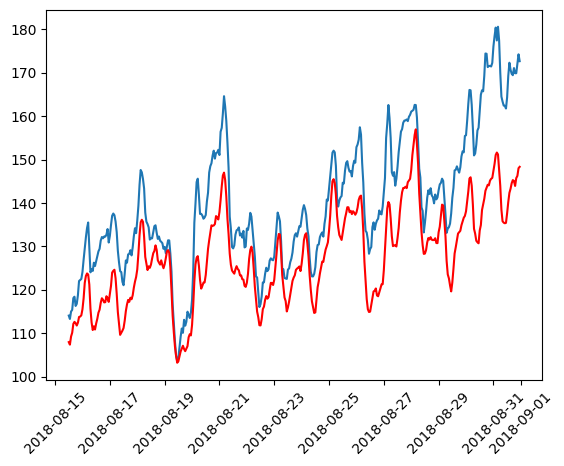

In [39]:
plot_by_predict(predict_3_0, test_target)

Модель переобучена, но результат лучше заданного порога.

**Заключение:**

в данных наблюдается недельная цикличность, количество заказов [зависит от дня недели](#tag_1). В период с марта по август 2018 года наблюдается выраженный восходящий тренд.

Лучшее предсказание дала модель линейной регрессии:
- RMSE: **29.23** (валидационная выборка) и **36.77** (тестовая выборка)

Все модели переобученны. Модель заполнения средним показали результат RMSE = **59.5**, что хуже заданного RMSE = **48**, а также показателей целевой метрики других моделей.